In [160]:
import os
if 'Conformal-Sparsemax/notebooks' in os.getcwd():
    os.chdir(os.path.dirname(os.getcwd()))

In [155]:
import scipy.stats as ss
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
import pickle
import pandas as pd

In [151]:
# x.sort()
# x = x[0,::-1]
# beta = 0.1
# for k in range(len(x)):
#     if 1+k*x[k]*beta <= np.sum(x[:k]*beta):
#         break
# (np.sum(x[:k]) - 1)/k

In [165]:
def custom_score(x):
    orig_x = x.copy()
    output = np.zeros(x.shape)
    for i in range(orig_x.shape[0]):
        x = orig_x[i].copy()
        x.sort()
        x = x[::-1]
        ranks = orig_x.shape[1]-ss.rankdata(orig_x[i])
        for k in range(orig_x.shape[1]):
            rank = int(ranks[k])
            output[i,k] = (np.sum(x[:rank]))/(rank+0.001) - x[rank]
    return output

In [187]:
# Get non-conformity scores
alpha = 0.1
pred_cal_path = 'predictions/CIFAR10_cal_FYLoss_logits_proba.pickle'
pred_test_path = 'predictions/CIFAR10_test_FYLoss_logits_proba.pickle'
true_cal_path = 'predictions/CIFAR10_cal_true.pickle'
true_test_path = 'predictions/CIFAR10_test_true.pickle'

def get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path):
    with open(pred_cal_path, 'rb') as f:
        pred_cal = pickle.load(f)
    with open(pred_test_path, 'rb') as f:
        pred_test = pickle.load(f)
    with open(true_cal_path, 'rb') as f:
        true_cal = pickle.load(f)
    with open(true_test_path, 'rb') as f:
        true_test = pickle.load(f)
    return pred_cal, pred_test, true_cal, true_test
    
def run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False):
    def get_pvalue(preds):
            return np.array([((cal_scores>= el).sum() + 1)/(len(cal_scores) + 1) for el in preds])
    
    #def cp_classifier(pred_cal, true_cal, pred_test, true_test, method='naive',alpha=0.1):
    n_cal, n_classes = pred_cal.shape 
    n_test = true_test.shape[0]
    #print(f'{n_cal} calibration points')
    #print(f'{n_test} test points')
    #print(f'{n_classes} classes')
    
    # Get calibration quantile
    true_mask = true_cal.astype(bool)
    cal_scores = 1 - pred_cal[true_mask]
    # cal_scores = custom_score(pred_cal)[true_mask]
    #cal_scores = ((1 - pred_cal[true_mask])/(n_classes-pred_cal.astype(bool).sum(axis=1).reshape((n_cal,1)).T)).T
    q_level = np.ceil((n_cal+1)*(1-alpha))/n_cal
    qhat = np.quantile(cal_scores, q_level) # check quantile method
    
    # test predictions
    test_scores = 1 - pred_test
    # test_scores = custom_score(pred_test)
    #alternative
    #test_scores = ((1 - pred_test)/(n_classes-pred_test.astype(bool).sum(axis=1).reshape((n_test,1))))
    test_match = test_scores<= qhat
    # get p-values 
    test_pvalues = np.apply_along_axis(get_pvalue,1,test_scores)
    p_values_cal = get_pvalue(cal_scores)
    
    # Set size and scores distribution
    set_size = test_match.sum(axis = 1)
    if plots:   
        fig, axs = plt.subplots(1,2,figsize=(12,6))
        axs[0].hist(set_size)
        axs[0].vlines(set_size.mean(),0,max(np.histogram(set_size, bins=10)[0])+10, color='black')
        axs[0].text(set_size.mean()*1.02,max(np.histogram(set_size, bins=10)[0]-10)*0.95,  f'S = {set_size.mean()}', color='black',fontweight='bold')
        axs[0].set_title('Set Size Distribution')
        
        axs[1].hist(cal_scores)
        axs[1].vlines(qhat,0,max(np.histogram(cal_scores, bins=10)[0])+10, color='black')
        axs[1].text(qhat*1.02,max(np.histogram(cal_scores, bins=10)[0]-10)*0.95, f'q={qhat:.3f}', color='black',fontweight='bold')
        axs[1].set_title('Non-Conf Scores Distribution')
        plt.show()
    coverage = test_match[true_test.astype(bool)].sum()/n_test
    #print(f'Coverage:{coverage}')
    class_coverage = (test_match & true_test).sum(axis = 0)/true_test.sum(axis=0)
    
    set_size = test_match.sum(axis = 1)
    #print(f'Avg set size:{set_size.mean()}')
    class_size = true_test.copy()
    class_size[class_size==1]=test_match.sum(axis = 1)
    class_size = class_size.sum(axis=0)/true_test.sum(axis=0)

    if plots:
    # Class-wise metrics
        fig, axs = plt.subplots(1,2,figsize=(12,6))
        # add labels?
        axs[0].bar(np.arange(n_classes),class_coverage)
        axs[0].hlines(coverage,0,n_classes-1, color='black')
        axs[0].hlines(1-alpha,0,n_classes-1, color='green')
        axs[0].text(0,coverage, f'Emp. cov. = {coverage:.2f}', color='black',fontweight='bold')
        axs[0].text(0,1-alpha, f'Theo. cov. = {1-alpha:.2f}', color='green',fontweight='bold')
        axs[0].set_title('Class Conditional Coverage')
        
        
        axs[1].bar(np.arange(n_classes),class_size)
        axs[1].hlines(set_size.mean(),0,100, color='black')
        axs[1].text(0,set_size.mean(), f'S={set_size.mean():.3f}', color='black',fontweight='bold')
        axs[1].set_title('Class Avg Set size')
        
        plt.show()
    
    # Observed fuzziness
    of = np.ma.array(test_pvalues, mask = true_test).mean(axis=1).data.mean()
    #print(f'OF={of:.4f}')
    return test_match, coverage, set_size.mean()

In [182]:
from tqdm import tqdm

In [183]:
pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)
alphas = np.linspace(0.001,0.4,20)
test_matches_custom = []
coverages_custom = []
avg_sizes_custom = []
for alpha in tqdm(alphas):
    test_match, coverage, avg_size = run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False)
    test_matches_custom.append(test_match)
    coverages_custom.append(coverage)
    avg_sizes_custom.append(avg_size)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:52<00:00,  2.60s/it]


In [189]:
# Get non-conformity scores
alpha = 0.1
pred_cal_path = 'predictions/CIFAR10_cal_FYLoss_softmax_proba.pickle'
pred_test_path = 'predictions/CIFAR10_test_FYLoss_softmax_proba.pickle'
true_cal_path = 'predictions/CIFAR10_cal_true.pickle'
true_test_path = 'predictions/CIFAR10_test_true.pickle'

In [190]:
pred_cal, pred_test, true_cal, true_test = get_data(pred_cal_path, pred_test_path,true_cal_path, true_test_path)
alphas = np.linspace(0.001,0.4,20)
test_matches_soft = []
coverages_soft = []
avg_sizes_soft = []
for alpha in alphas:
    test_match, coverage, avg_size = run_cp(pred_cal, pred_test, true_cal, true_test, alpha, plots = False)
    test_matches_soft.append(test_match)
    coverages_soft.append(coverage)
    avg_sizes_soft.append(avg_size)

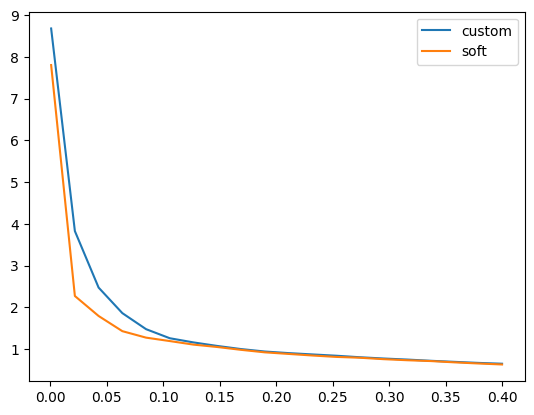

In [196]:
plt.plot(alphas,avg_sizes_custom,label='custom')
plt.plot(alphas,avg_sizes_soft,label='soft')
plt.legend()
plt.show()

In [197]:
from entmax import sparsemax
import torch

In [222]:
n_test = pred_test.shape[0]
betas = np.linspace(1,20,20)
coverages = []
avg_sizes = []
for beta in betas:
    sparse_pred = sparsemax(torch.tensor(pred_test)*beta, dim = -1)
    sparse_pred = sparse_pred.numpy()
    pred_match = sparse_pred>0
    coverages.append(pred_match[true_test.astype(bool)].sum()/n_test)
    avg_sizes.append(pred_match.sum(axis = 1).mean())

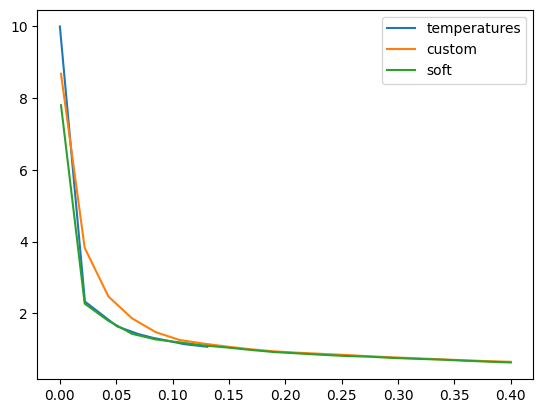

In [223]:
plt.plot([1-c for c in coverages],avg_sizes,label='temperatures')
plt.plot(alphas,avg_sizes_custom,label='custom')
plt.plot(alphas,avg_sizes_soft,label='soft')
plt.legend()
plt.show()